In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.kernel_ridge import KernelRidge

In [61]:
embedding_path = "../experiments/workflow/wandb/offline-run-20230511_222802-32gyt2yh/tmp/embedding_dv.csv"
label_path = "../data/data.csv"
id_column = "cif.label"
target = "logKH_CO2"

In [62]:
df = pd.read_csv(embedding_path)
df_label = pd.read_csv(label_path)
df_label = df_label.rename(columns={id_column: "type"})
subdf_label = df_label[["type", target]]
df = df.merge(subdf_label)
df.head()

,type,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,...,x_119,x_120,x_121,x_122,x_123,x_124,x_125,x_126,x_127,logKH_CO2
0,RSM0001,0.102612,0.072050,-0.034977,0.004111,0.114863,-0.081922,-0.015612,0.295485,-0.319612,...,-0.034360,0.089289,-0.130934,0.382795,0.065420,-0.051555,-0.136035,-0.421288,0.019107,-3.804233
1,RSM0002,0.346892,0.481182,0.038204,-0.232912,0.034055,-0.120156,-0.246855,0.085906,-0.177270,...,-0.087687,-0.058271,0.007946,0.094269,0.188917,0.076348,-0.260514,0.153950,-0.123107,-3.239400
2,RSM0003,0.221942,0.434560,0.073304,-0.249969,-0.120470,-0.152858,-0.241768,0.278346,-0.377520,...,0.149407,-0.111832,0.145833,0.256955,0.133413,0.014466,-0.380352,0.115316,-0.211523,-3.717419
3,RSM0004,0.414539,0.253319,-0.035338,-0.072951,0.259356,0.054976,0.022072,0.224314,-0.340947,...,-0.030032,0.029633,0.244588,0.179329,0.118986,-0.141401,-0.093432,-0.166796,-0.263204,-3.269990
4,RSM0008,0.237583,0.375270,0.006462,0.009740,-0.009141,-0.079222,-0.103903,-0.073470,-0.001866,...,0.053949,-0.052754,0.187827,0.167157,0.151249,-0.156836,0.026840,0.101744,-0.112862,-0.954231


In [5]:
X = df.drop(['type', target], axis=1).values
y = df[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Random state ensures that the splits that you generate are reproducible. 
# Scikit-learn uses random permutations to generate the splits. 
# The random state that you provide is used as a seed to the random number generator.
# This ensures that the random numbers are generated in the same order.

In [63]:
x_scaler = MinMaxScaler().fit(X_train)
y_scaler = MinMaxScaler().fit(y_train.reshape(-1,1))

X_train_scaled = x_scaler.transform(X_train)
y_train_scaled = y_scaler.transform(y_train.reshape(-1,1))

X_test_scaled = x_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test.reshape(-1,1))

In [50]:
X_train = torch.FloatTensor(X_train)
X_train_scaled = torch.FloatTensor(X_train_scaled)
X_test = torch.FloatTensor(X_test)
X_test_scaled = torch.FloatTensor(X_test_scaled)

y_train = torch.FloatTensor(y_train)
y_train_scaled = torch.FloatTensor(y_train_scaled)
y_test = torch.FloatTensor(y_test)
y_test_scaled = torch.FloatTensor(y_test_scaled)

In [51]:
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=512, out_features=1000)
        self.fc2 = nn.Linear(in_features=1000, out_features=1000)
        self.fc3 = nn.Linear(in_features=1000, out_features=1000)
        self.fc4 = nn.Linear(in_features=1000, out_features=1000)
        self.output = nn.Linear(in_features=1000, out_features=1)
 
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.output(x)
        return x

In [71]:
model = ANN()
model

ANN(
  (fc1): Linear(in_features=512, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=1000, bias=True)
  (fc4): Linear(in_features=1000, out_features=1000, bias=True)
  (output): Linear(in_features=1000, out_features=1, bias=True)
)

In [73]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.9e-3)

In [72]:
epochs = 500
loss_arr = []
loss_arr_scaled = []

for i in range(epochs):
    y_hat = model.forward(X_train_scaled)
    loss = criterion(y_hat, y_train_scaled.view(-1,1))
    loss_arr.append(loss.detach().numpy())
    loss_scaled = mean_squared_error(y_scaler.inverse_transform(y_hat.detach().numpy()), y_scaler.inverse_transform(y_train_scaled))
    loss_arr_scaled.append(loss_scaled)
 
    if i % 10 == 0:
        print(f'Epoch: {i} Loss: {loss_scaled}')
 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0 Loss: 15.04889591623729
Epoch: 10 Loss: 15.04889591623729
Epoch: 20 Loss: 15.04889591623729
Epoch: 30 Loss: 15.04889591623729
Epoch: 40 Loss: 15.04889591623729
Epoch: 50 Loss: 15.04889591623729
Epoch: 60 Loss: 15.04889591623729
Epoch: 70 Loss: 15.04889591623729
Epoch: 80 Loss: 15.04889591623729
Epoch: 90 Loss: 15.04889591623729
Epoch: 100 Loss: 15.04889591623729
Epoch: 110 Loss: 15.04889591623729
Epoch: 120 Loss: 15.04889591623729
Epoch: 130 Loss: 15.04889591623729
Epoch: 140 Loss: 15.04889591623729
Epoch: 150 Loss: 15.04889591623729
Epoch: 160 Loss: 15.04889591623729
Epoch: 170 Loss: 15.04889591623729
Epoch: 180 Loss: 15.04889591623729
Epoch: 190 Loss: 15.04889591623729
Epoch: 200 Loss: 15.04889591623729
Epoch: 210 Loss: 15.04889591623729
Epoch: 220 Loss: 15.04889591623729
Epoch: 230 Loss: 15.04889591623729
Epoch: 240 Loss: 15.04889591623729
Epoch: 250 Loss: 15.04889591623729
Epoch: 260 Loss: 15.04889591623729
Epoch: 270 Loss: 15.04889591623729
Epoch: 280 Loss: 15.04889591623

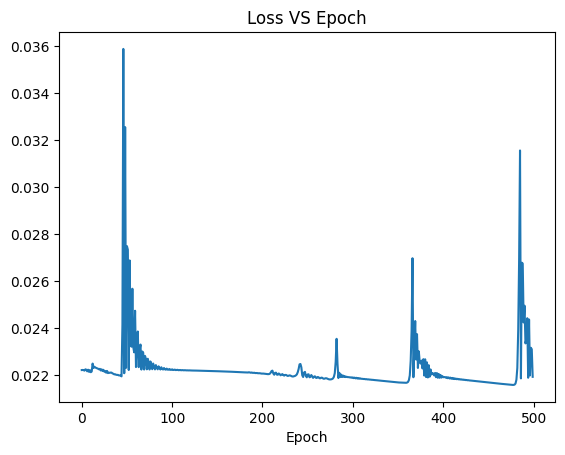

In [69]:
plt.title('Loss VS Epoch')
plt.xlabel("Loss")
plt.xlabel("Epoch")
plt.plot(loss_arr)

In [60]:
preds = []
with torch.no_grad():
    for val in X_test_scaled:
        y_hat = model.forward(val)
        preds.append(y_scaler.inverse_transform(y_hat.detach().numpy().reshape(-1,1)))

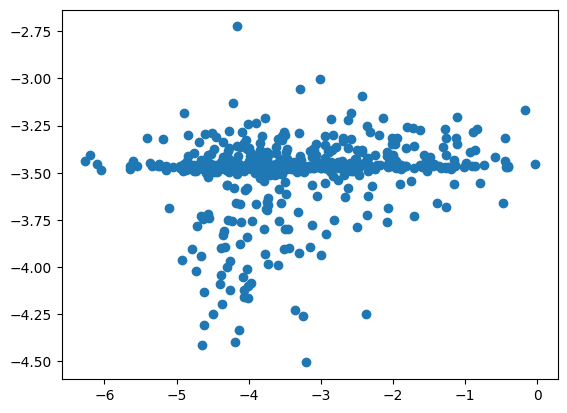

In [61]:
plt.scatter(y_test, preds)
#plt.xlim([-7,0])
#plt.ylim([-7,0])

# KRR

In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

In [113]:
alpha = 0.1
gamma = 0.1
kernel = 'laplacian'

In [127]:
param_grid = {
                'alpha': np.logspace(-2, 0, 100),
                'gamma': np.logspace(-3, 0, 100)
            }

In [128]:
krr = KernelRidge(kernel=kernel)
random_krr = RandomizedSearchCV(krr, param_distributions=param_grid, n_iter=10,
                        cv=10, verbose=2, n_jobs=6
)

In [129]:
random_krr.fit(X_train_scaled, y_train_scaled)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END alpha=0.2848035868435802, gamma=0.01747528400007684; total time=   3.0s
[CV] END alpha=0.2848035868435802, gamma=0.01747528400007684; total time=   3.0s
[CV] END alpha=0.2848035868435802, gamma=0.01747528400007684; total time=   3.0s
[CV] END alpha=0.2848035868435802, gamma=0.01747528400007684; total time=   3.1s
[CV] END alpha=0.2848035868435802, gamma=0.01747528400007684; total time=   3.1s
[CV] END alpha=0.2848035868435802, gamma=0.01747528400007684; total time=   3.3s
[CV] END alpha=0.2848035868435802, gamma=0.01747528400007684; total time=   3.2s
[CV] END alpha=0.2848035868435802, gamma=0.01747528400007684; total time=   3.3s
[CV] END alpha=0.6579332246575682, gamma=0.004037017258596553; total time=   3.1s
[CV] END alpha=0.2848035868435802, gamma=0.01747528400007684; total time=   3.2s
[CV] END alpha=0.2848035868435802, gamma=0.01747528400007684; total time=   3.2s
[CV] END alpha=0.6579332246575682, gamma=0.00

RandomizedSearchCV(cv=10, estimator=KernelRidge(kernel='laplacian'), n_jobs=6,
                   param_distributions={'alpha': array([0.01      , 0.01047616, 0.01097499, 0.01149757, 0.01204504,
       0.01261857, 0.01321941, 0.01384886, 0.01450829, 0.01519911,
       0.01592283, 0.01668101, 0.01747528, 0.01830738, 0.0191791 ,
       0.02009233, 0.02104904, 0.02205131, 0.0231013 , 0.02420128,
       0.02535364, 0.02656088, 0.02...
       0.09326033, 0.1       , 0.10722672, 0.1149757 , 0.12328467,
       0.13219411, 0.14174742, 0.15199111, 0.16297508, 0.17475284,
       0.18738174, 0.2009233 , 0.21544347, 0.23101297, 0.24770764,
       0.26560878, 0.28480359, 0.30538555, 0.32745492, 0.35111917,
       0.37649358, 0.40370173, 0.43287613, 0.46415888, 0.49770236,
       0.53366992, 0.57223677, 0.61359073, 0.65793322, 0.70548023,
       0.75646333, 0.81113083, 0.869749  , 0.93260335, 1.        ])},
                   verbose=2)

In [130]:
y_train_pred = y_scaler.inverse_transform(random_krr.best_estimator_.predict(X_train_scaled).reshape(-1,1))
y_test_pred = y_scaler.inverse_transform(random_krr.best_estimator_.predict(X_test_scaled).reshape(-1,1))

In [134]:
print('Train/test MAE: ', mean_absolute_error(y_train, y_train_pred),
	  mean_absolute_error(y_test, y_test_pred))
print('Train/test MSE: ', mean_squared_error(y_train, y_train_pred, squared=False),
	  mean_squared_error(y_test, y_test_pred, squared=False))
print('Train/test r2: ', r2_score(y_true=y_train, y_pred=y_train_pred),
	  r2_score(y_true=y_test, y_pred=y_test_pred))

Train/test MAE:  0.48406563011823356 0.7518896897844239
Train/test MSE:  0.6683639750047873 0.9711608423549994
Train/test r2:  0.5774546688189779 0.17668702796588853


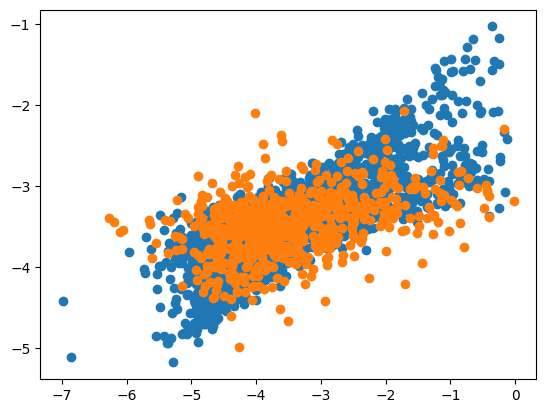

In [133]:
plt.scatter(y_train, y_train_pred)
plt.scatter(y_test, y_test_pred)